# Ensembale Mode here
Combine all the sub-model with Bagging method

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy
import json
import seaborn as sns
from collections import namedtuple
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import matplotlib.pyplot as plt

### Figure the basic value

In [2]:
model_path = 'Choesn_model/'
configure_file_path = 'Choesn_model/Configuration.json'

TRAINFILE = 'keyword.csv'
TESTFILE = 'key_word_test.csv'
boolean = 'True'

## Define the MODEL object

In [3]:
class Model(object):

    def  __init__(self, model, name, test_set, topic, is_preprocess, level):
        self.model = model
        self.name = name
        self.test_set = test_set
        self.topic = topic
        self.is_preprocess = is_preprocess
        self.level = level
        self.encoding = None

    # for debug use
    def show(self):
        print(
            self.name,'\t',
            self.test_set,'\t',
            self.topic,'\t',
            self.is_preprocess,'\t',
            self.level
        )

    def predict(self, x):
        if self.level == 1:
            pred_y = self.model.predict(x)
            for i in range(pred_y.shape[0]):
                pred_y[i] = self.convert(str(pred_y[i]))
            
            return pred_y.astype(int)
        else:
            return self.model.predict(x)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

    def set_encoding(self, encoding):
        self.encoding = encoding

    def convert(self, x):
        return int(self.encoding[x])


## Load the model detail from json figuration file

In [4]:
def load_configuration_to_model(file_path):
    '''
    Load the json file and figure the parameter of each model

    Return: (Tuple Object) with two sub-list
            sub-list_1: Model for layer one (For revelent and irrevelent)
            sub-list_2: Model for layer two (For topic decision)
    '''

    with open(configure_file_path, 'r') as json_fp:
        configuration = json.load(json_fp)

    layer_1 = []
    layer_2 = []
    
    for model_figure in configuration:

        # read the figure
        model_file = joblib.load(model_path + model_figure['model_name'])
        name = model_figure['model_name']
        test_set = model_figure['test_set']
        topic = model_figure['topic']
        is_preprocess = boolean == model_figure['preprocess']
        level = int(model_figure['level'])

        # New model object to save those arguments
        model = Model(model_file, name, test_set, topic, is_preprocess, level)

        # append to model list for futher processing
        if level == 1:
            model.set_encoding(model_figure['encoding'])
            layer_1.append(model)
        elif level == 2:
            layer_2.append(model)

    return layer_1,layer_2


## Prepare the testing data and preprocess vector

In [5]:
def get_vector(column_name, special=False):
    '''
    df                      str: The train df
    fit_column              str: The column for vector to fit

    Return: (Vectorizer Object)
            Vectorizer of current column
    '''
    train_df = pd.read_csv(TRAINFILE)
    if special is not False:
        train_df = train_df.dropna()
        train_df[special] = train_df[special].apply(lambda x: x.replace('_', ''))

    # prepare the tranform vector
    vector = TfidfVectorizer().fit(train_df[column_name])

    return vector

def preprocess(df, column_name_list):
    '''
    This function to use to prepare all the data for ensemble system running
    including RAW data and Vector-preprocess data

    Return: (Dict object)
            A after preprocessing data dict, it order by column_name_list
        
            ext:
            Input: column_name_list: ['key_word_100', 'article_words']
            Output: test_data_dict: test_data_dict['key_word_100'] --> key_word_100
                                    test_data_dict['article_words'] -> article_words
                                    test_data_dict['raw']          --> original data
    '''

    test_data_dict = {}

    # first add original data
    test_data_dict['raw'] = df

    vector = get_vector('article_words', special='article_words')
    
    for column in column_name_list:
        en_data = vector.transform(df[column])
        test_data_dict[str(column)] = en_data

    # for special data, add it by manul
    vector = get_vector('key_word_100')
    test_data_dict['key_word_100_1'] = vector.transform(df['key_word_100'])

    return test_data_dict


In [6]:
df = pd.read_csv(TESTFILE)
dict_data = preprocess(df, ['key_word_100', 'article_words'])

## Brad's work

In [139]:
model_list_1, model_list_2 = load_configuration_to_model(configure_file_path)
print([i.show() for i in model_list_1],[i.show() for i in model_list_2])

svm_ir_clf.joblib 	 key_word_100_1 	 ['IRRELEVANT'] 	 True 	 1
rel_clf_tfidf_NB.joblib 	 article_words 	 ['IRRELEVANT'] 	 False 	 1
best_logi.joblib 	 article_words 	 ['IRRELEVANT'] 	 False 	 1
tfidf_logi_pipe.joblib 	 key_word_50 	 ['ARTS CULTURE ENTERTAINMENT', 'DOMESTIC MARKETS', 'SPORTS', 'SHARE LISTINGS', 'FOREX MARKETS', 'DEFENCE'] 	 False 	 2
clf_NB_1.joblib 	 key_word_50 	 ['SHARE LISTINGS', 'DOMESTIC MARKETS', 'ARTS CULTURE ENTERTAINMENT', 'SPORTS', 'DEFENCE', 'FOREX MARKETS', 'SCIENCE AND TECHNOLOGY'] 	 False 	 2
clf_NB_2.joblib 	 key_word_100 	 ['SHARE LISTINGS', 'DOMESTIC MARKETS', 'SPORTS', 'HEALTH', 'MONEY MARKETS', 'DEFENCE'] 	 False 	 2
clf_NB_3.joblib 	 key_word_50 	 ['BIOGRAPHIES PERSONALITIES PEOPLE'] 	 False 	 2
svm_proba_1.joblib 	 key_word_100 	 ['DOMESTIC MARKETS', 'SHARE LISTINGS', 'ARTS CULTURE ENTERTAINMENT', 'SPORTS', 'DEFENCE', 'FOREX MARKETS', 'BIOGRAPHIES PERSONALITIES PEOPLE'] 	 True 	 2
svm_proba_2.joblib 	 article_words 	 ['DOMESTIC MARKETS', 'SPORTS', 

In [8]:
topic_encode = dict()
topic_decode = dict()

topic_list = list(set(df['topic']))
topic_list.sort()
for num, topic in enumerate(topic_list):
    topic_decode[num] = topic
    topic_encode[topic] = num
print(topic_encode)
print(topic_decode)

SAMPLE_SIZE = len(df)

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
{0: 'ARTS CULTURE ENTERTAINMENT', 1: 'BIOGRAPHIES PERSONALITIES PEOPLE', 2: 'DEFENCE', 3: 'DOMESTIC MARKETS', 4: 'FOREX MARKETS', 5: 'HEALTH', 6: 'IRRELEVANT', 7: 'MONEY MARKETS', 8: 'SCIENCE AND TECHNOLOGY', 9: 'SHARE LISTINGS', 10: 'SPORTS'}


In [9]:
Vote = namedtuple("Vote", "model cate proba")

In [24]:
def vote_proba(votes, topic_dict):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # no vote
        if max_vote == 0:
            res = [None, None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

In [11]:
def irre_vote(model_list, sample_size):
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
            print(clf.name)
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.predict(test_x)
            y_pred_proba = clf.predict_proba(test_x)
            print(y_pred)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]

                clf_name = clf.name.split('.')[0]
                # create namedtuple (model_name, category, category_proba)
                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    topic_dict = {0: 'IRRELEVANT', 1: 'RELEVANT'}
    return vote_proba(all_votes, topic_dict)

In [12]:
irre_df = irre_vote(model_list_1, SAMPLE_SIZE)

svm_ir_clf.joblib
[0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 

In [13]:
irre_df

,predict,mean_proba,models,probas
0,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
2,RELEVANT,0.809855,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.949771764091339, 1.0, 0.47979271676817054]"
3,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...
495,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
496,RELEVANT,0.985749,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9639243912490126, 1.0, 0.9933233114016177]"
497,RELEVANT,0.893329,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415672706585443, 1.0, 0.7384200805379728]"
498,RELEVANT,0.677644,"[rel_clf_tfidf_NB, best_logi]","[1.0, 0.355288766615221]"


In [14]:
def cate_vote(model_list, sample_size, irre_res, truth):
    
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        print(clf.name)
        if clf.is_preprocess is True:
            test_x = dict_data[clf.test_set]
        else:
            test_x = dict_data['raw'][clf.test_set]
        y_pred = clf.predict(test_x)
        y_pred_proba = clf.predict_proba(test_x)
        print(y_pred)
        for i in range(sample_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            if topic_decode[cate] in clf.topic:
                            
                clf_name = clf.name.split('.')[0]

                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    rela_res = vote_proba(all_votes, topic_decode)
    for i in range(sample_size):
        if irre_res['predict'].iloc[i] == 'IRRELEVANT':
            final_res = [truth[i]] + irre_res.iloc[i].tolist()
        else:
            final_res = [truth[i]] + rela_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

In [15]:
res_df = cate_vote(model_list_2, SAMPLE_SIZE, irre_df, df['topic'])

tfidf_logi_pipe.joblib
[ 6  6  7  3  6  4  2 10  7  6  6  6 10  6  3  7  6  9  3 10  4  7  6  6
  7  1  6  6  4  4  4  7  7  7  6 10  3  2  4  0 10  7  6  6  3  6  7  4
  6  4  4  3  7  4  7  0  6  6  2  4  7  9  6  7  4  6  4 10 10  4  7  4
 10 10  1  2  4  6  2 10  9  6  7  4  6  7  7  4  7  6  6  6  4  7  6 10
 10  6  7  7  9  7  6  0  9  7  2 10  5 10  9  8  4  9  6  2  8  7  6 10
  8  6  7  6  4  7  7  2  5 10  3  4  6  4  6  6  6  7  6  3  7  6  3  6
  3  6  7  6  6  4  6  9 10  6  9 10 10  6  4  1  5 10 10  6  7  9  9  9
  6  6  4  4  6  6  6  7  7  4  6  7  3  4  7  9  7  6  6  9  6  6  7  6
  4 10 10  4  3  6  6  6 10  4  0  4  9  2  7  7  7  7  4  9  2  7  9  6
  6  4  6  0  2  6  7  6  4  6  9  6  7  6  2  6  4  4  5 10  7 10  2  4
  4  6  4  6  6  7  9  4  7  3  7 10  7 10  7  6  0  5  6 10  7  3 10  1
  7  7  3  1  7  2  6  4  2 10  6  4  6  6  7  3  2 10  1  7  6  4 10  8
  0  1 10  7  6  6  6  3  1  4  6 10 10  6  7  6  7  7  5  6 10  5 10  6
 10  6  1  7 10 10  6  7 10 

[ 6  6  7  6  6  4  7 10  7  6  6  6 10 10  3  6  6  9  3 10  4  6  6  6
  4  6  6  9  6  7  7  6  6  7  6 10  3  6  7  9  6  4  6  6  6  6  7  4
  6  4  7  6  6  7  4  6  6  6  0  7  6  6  6  9  7  6  6 10 10  7  7  6
 10 10  6  2  4  6  6 10  9 10  7  7  6  7  7  4  4  6  6  0  6  7  6 10
 10  6  7  7  9  7  6  6  6  6 10 10  6 10  4  6  6  9  6  6  6  7  4 10
  5  6  1  6  4  6  4  6  6 10  6  7  7  7  6  6  6  7  6  6  4  6  6  6
  6  6  7  6  9  4  6  6 10  6  9 10 10  9  4  6  5 10 10  6  4  9  9  4
  6  2  7  7  6  6  6  7  4  4  2  7  3  4  4  6  6  6  6  6  6  6  7  6
  4 10 10  9  6  8  6  6 10  7  0  4  6  2  7  4  6  6  4  6  2  1  9  6
  6  7  6  6  6  6  6  6  7  6  6  6  4  6  2  6  7  7  5 10  7 10  2  4
  6  6  4  7  6  8  9  7  6  6  7  6  4 10 10  6  6  0  6 10  7  6 10  6
  6  7  6  6  7  5  6  4  6 10  6  7  6  6  6  6  6 10  1 10  6  4 10  6
  6  6 10  6  6  6  6  6 10  4  3 10 10  6  7  6  6  4  3  6 10  1 10  7
 10  6  6  7 10  6  0  7 10  7  6  4  6  4  6  7  4

In [16]:
# if there is None, uncomment this
# res_df.loc[res_df.predict.isnull()] = 'IRRELEVANT'

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.38      1.00      0.55         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.78      0.47      0.58        15
                         DEFENCE       0.90      0.69      0.78        13
                DOMESTIC MARKETS       0.50      0.50      0.50         2
                   FOREX MARKETS       0.47      0.90      0.61        48
                          HEALTH       0.69      0.64      0.67        14
                      IRRELEVANT       0.91      0.87      0.89       266
                   MONEY MARKETS       0.63      0.35      0.45        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.56      0.71      0.63         7
                          SPORTS       0.92      1.00      0.96        60

                        accuracy                           0.79       500
             

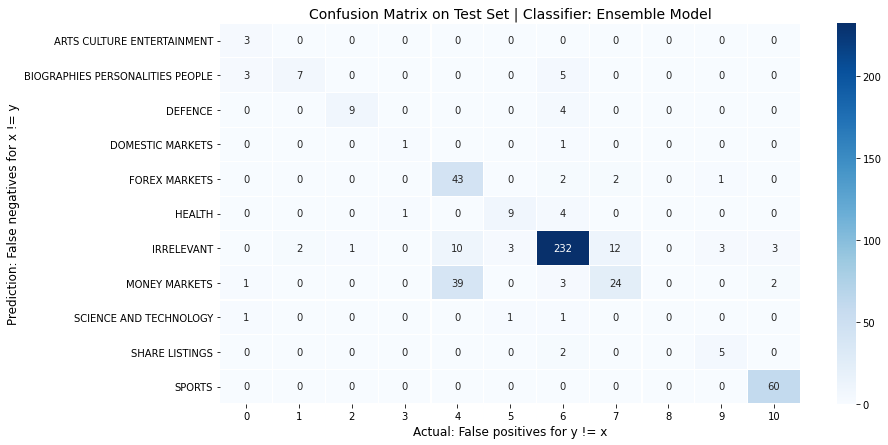

In [17]:
def report(test_y, y_pred):
    global topic_list

    print(f"Classification Report:\n{classification_report(test_y, y_pred)}")
#     print("The scores for each topic is:")
#     scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,7))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=topic_list,
#                 xticklabels=topic_list,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: Ensemble Model", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

report(res_df['label'], res_df['predict'])

DEFENCE accuarcy is:				 0.6923076923076923
DOMESTIC MARKETS accuarcy is:				 0.5
MONEY MARKETS accuarcy is:				 0.34782608695652173
FOREX MARKETS accuarcy is:				 0.8958333333333334
SPORTS accuarcy is:				 1.0
SHARE LISTINGS accuarcy is:				 0.7142857142857143
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is:				 0.4666666666666667
HEALTH accuarcy is:				 0.6428571428571429
ARTS CULTURE ENTERTAINMENT accuarcy is:				 1.0
SCIENCE AND TECHNOLOGY accuarcy is:				 0.0
IRRELEVANT accuarcy is:				 0.8721804511278195


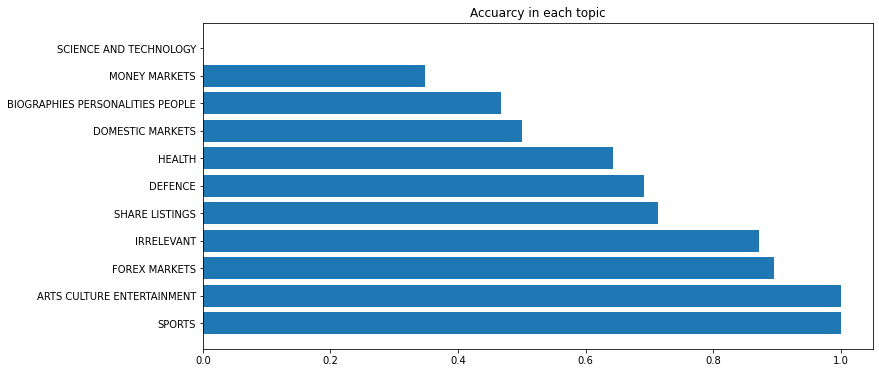

In [18]:
def evaluate(res_df, y_true_label, y_pred_label):
    '''
    Here is for the evaluate the ensamble model

    Input: (DataFrame Object) Should be result of the prediction
    Output: 
    '''

    report = []
    topic_list = list(set(res_df[y_true_label]))
    for topic in topic_list:

        # prepare the record
        topic_report = {}
        topic_report['name'] = str(topic)

        # prepare the evaluate data
        test_df = res_df[res_df[y_true_label] == topic]

        #evaluate each part
        topic_report['f1_score'] = metrics.f1_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        topic_report['accuarcy'] = metrics.accuracy_score(test_df[y_true_label], test_df[y_pred_label])
        topic_report['recall_score'] = metrics.recall_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        print(topic,'accuarcy is:\t\t\t\t', topic_report['accuarcy'])

        # append t total report for further
        report.append(topic_report)
        

    # sort the report for plt
    report.sort(reverse=True, key=lambda x: x['accuarcy'])

    #plt.style.use('ggplot')
    figure = plt.figure(figsize=(12,6))
    #plt.xticks(rotation=90)
    plt.title('Accuarcy in each topic')
    plt.barh([i['name'] for i in report], [j['accuarcy'] for j in report])

    plt.show()

evaluate(res_df, 'label', 'predict')


In [19]:
temp_rs_df = res_df[res_df['label'] == 'IRRELEVANT']
temp_rs_df

,label,predict,mean_proba,models,probas
0,IRRELEVANT,IRRELEVANT,0.85546,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
3,IRRELEVANT,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
6,IRRELEVANT,IRRELEVANT,0.857133,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8658562226628614, 1.0, 0.705542322929795]"
...,...,...,...,...,...
488,IRRELEVANT,IRRELEVANT,0.858489,"[svm_ir_clf, rel_clf_tfidf_NB]","[0.7169770939662491, 1.0]"
490,IRRELEVANT,IRRELEVANT,0.821487,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9277460669417049, 1.0, 0.536715232310648]"
492,IRRELEVANT,IRRELEVANT,0.838036,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9402443410480955, 1.0, 0.5738634061656198]"
495,IRRELEVANT,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"


In [20]:
temp_rs_df = res_df[res_df['label'] == 'BIOGRAPHIES PERSONALITIES PEOPLE']
temp_rs_df
print('For not corrcet prediction')
no_correct = temp_rs_df[temp_rs_df['predict'] != 'BIOGRAPHIES PERSONALITIES PEOPLE']
no_correct



For not corrcet prediction


,label,predict,mean_proba,models,probas
80,BIOGRAPHIES PERSONALITIES PEOPLE,IRRELEVANT,0.812736,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8987773645522399, 1.0, 0.539429660328727]"
267,BIOGRAPHIES PERSONALITIES PEOPLE,IRRELEVANT,0.908493,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9261901825678165, 1.0, 0.7992895558077636]"
282,BIOGRAPHIES PERSONALITIES PEOPLE,IRRELEVANT,0.731552,"[svm_ir_clf, best_logi]","[0.8199555314762236, 0.6431475892186023]"
288,BIOGRAPHIES PERSONALITIES PEOPLE,ARTS CULTURE ENTERTAINMENT,0.994053,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1]","[0.999995684598029, 1.0, 0.982163650771372]"
329,BIOGRAPHIES PERSONALITIES PEOPLE,ARTS CULTURE ENTERTAINMENT,0.999147,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1]","[0.9976895900514323, 1.0, 0.9997517201501492]"
432,BIOGRAPHIES PERSONALITIES PEOPLE,ARTS CULTURE ENTERTAINMENT,0.994979,"[tfidf_logi_pipe, clf_NB_1, svm_proba_1]","[0.9999999996591098, 1.0, 0.9849355928393099]"
455,BIOGRAPHIES PERSONALITIES PEOPLE,IRRELEVANT,0.579564,"[svm_ir_clf, best_logi]","[0.6243131545534658, 0.5348144300028544]"
482,BIOGRAPHIES PERSONALITIES PEOPLE,IRRELEVANT,0.72819,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.5213612083655645, 1.0, 0.6632099125938061]"


In [21]:
# calculate the incorrect model vote time:
vote_time = {}
for index, row in no_correct.iterrows():
    for model in row['models']:
        if model not in vote_time:
            vote_time[model] = 1
        else:
            vote_time[model] += 1

for model in vote_time:
    print(model, 'was vote for', vote_time[model], 'times')

svm_ir_clf was vote for 5 times
rel_clf_tfidf_NB was vote for 3 times
best_logi was vote for 5 times
tfidf_logi_pipe was vote for 3 times
clf_NB_1 was vote for 3 times
svm_proba_1 was vote for 3 times


In [22]:
# check json topics
for model in model_list_1 + model_list_2:
    for topic in model.topic:
        if topic not in topic_list:
            print(topic)

In [136]:
# ADD_WEIGHT_LIST = [0 for _ in topic_list]
# ADD_WEIGHT_LIST[topic_encode['BIOGRAPHIES PERSONALITIES PEOPLE']] = 2
# ADD_WEIGHT_LIST[topic_encode['HEALTH']] = 1
# ADD_WEIGHT_LIST[topic_encode['MONEY MARKETS']] = 3

topic_count = {}
for topic in topic_list:
    topic_count[topic] = 0
    
for model in model_list_1 + model_list_2:
    for topic in model.topic:
        topic_count[topic] += 1
ADD_WEIGHT_LIST = [topic_count[max(topic_count)]-i for i in topic_count.values()]
ADD_WEIGHT_LIST

def vote_proba_2(votes, topic_dict):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
                
        ###### add weight ######
        for i in range(len(vote_count)):
            if vote_count[i] > 0:
                vote_count[i] += ADD_WEIGHT_LIST[i]
        ########################
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # no vote
        if max_vote == 0:
            res = [None, None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

IRRE_ENCODE_1 = 0
IRRE_ENCODE_2 = topic_encode['IRRELEVANT']

def cate_vote_2(model_list, sample_size, truth):            
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        print(clf.name)
        if clf.is_preprocess is True:
            test_x = dict_data[clf.test_set]
        else:
            test_x = dict_data['raw'][clf.test_set]
        y_pred = clf.predict(test_x)
        y_pred_proba = clf.predict_proba(test_x)
        print(y_pred)
        for i in range(sample_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            clf_name = clf.name.split('.')[0]
                            
            # if level 1 and IRRELEVANT, add to vote
            if clf.level ==1 and cate == IRRE_ENCODE_1:
                all_votes[i].append(Vote(clf_name, IRRE_ENCODE_2, proba.max()))
            elif clf.level == 2 and topic_decode[cate] in clf.topic:
                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    vote_res = vote_proba_2(all_votes, topic_decode)
    for i in range(sample_size):
        final_res = [truth[i]] + vote_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

res_df = cate_vote_2(model_list_1 + model_list_2, SAMPLE_SIZE, df['topic'])

svm_ir_clf.joblib
[0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 

svm_proba_1.joblib
[ 3  6  4  6  6  4  2 10  7  9  9  6 10 10  6  7  6  9  3 10  6  4  7  6
  7  1  6  7  4  4  4  4  1  7  6 10  3  6  4  6 10  4  6  8  2  1  7  4
  3  4  4  3  7  4  4  6  9  6  2  7  4  9  9  4  4  6  4 10 10  4  7  4
 10 10  1  2  4  6  2 10  9  1  7  4  6  7  7  4  4  6  3  6  6  4  6 10
 10  6  4  7  9  7  6  1  9  7  2 10  5 10  4  6  4  9  6  2  8  7  2 10
  5  9  7  6  4  4  4  6  6 10  6  4  6  4  6  6  6  7  6  3  7  6  3  6
  1  6  4  2  4  4  3  9 10  9  9 10 10  9  4  6  5 10 10  6  4  9  9  6
  1  2  4  7  2  6  7  4  4  4  2  7  6  4  7  9  4  6  6  9  3  6  7  3
  4 10 10  4  3  1  6  9 10  4  0  4  6  2  7  4  4  4  4  9  2  2  9  6
  4  4  6  7  2  8  7  1  4  6  9  6  4  9  2  9  4  4  5 10  7 10  2  4
  2  9  4  7  6  7  9  4  7  3  4 10  3 10  7  6 10  1  2 10  7  6 10  1
  7  7  3  1  7  2  2  4  2 10  5  4  2  7  4  3  9 10  2  4  6  4 10  6
  0  6 10  7  6  6  3  3  1  4  1 10 10  3  7  9  7  4  5  6 10  5 10  9
 10  6  2  7 10 10  6  7 10  7  

In [137]:
res_df

,label,predict,mean_proba,models,probas
0,IRRELEVANT,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
2,FOREX MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[0.9999999999997726]
3,IRRELEVANT,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...,...
495,IRRELEVANT,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
496,SPORTS,SPORTS,1.000000,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[1.0, 1.0, 1.0, 0.9999999995165704, 0.99999995..."
497,MONEY MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[1.0]
498,SHARE LISTINGS,SHARE LISTINGS,0.972932,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[0.8917285046808255, 1.0, 1.0, 0.9999995012957..."


Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.38      1.00      0.55         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.52      0.73      0.61        15
                         DEFENCE       0.63      0.92      0.75        13
                DOMESTIC MARKETS       0.15      1.00      0.27         2
                   FOREX MARKETS       0.57      0.79      0.66        48
                          HEALTH       0.73      0.79      0.76        14
                      IRRELEVANT       0.96      0.73      0.83       266
                   MONEY MARKETS       0.55      0.67      0.61        69
          SCIENCE AND TECHNOLOGY       0.50      0.33      0.40         3
                  SHARE LISTINGS       0.56      0.71      0.63         7
                          SPORTS       0.95      0.95      0.95        60

                        accuracy                           0.76       500
             

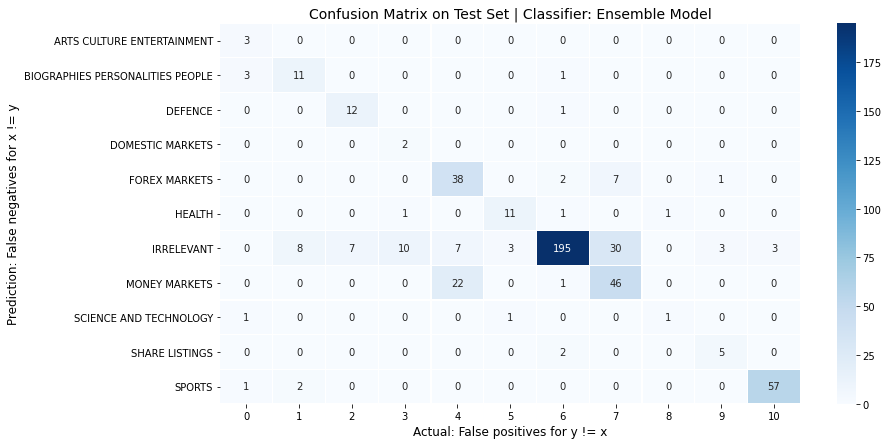

DEFENCE accuarcy is:				 0.9230769230769231
DOMESTIC MARKETS accuarcy is:				 1.0
MONEY MARKETS accuarcy is:				 0.6666666666666666
FOREX MARKETS accuarcy is:				 0.7916666666666666
SPORTS accuarcy is:				 0.95
SHARE LISTINGS accuarcy is:				 0.7142857142857143
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is:				 0.7333333333333333
HEALTH accuarcy is:				 0.7857142857142857
ARTS CULTURE ENTERTAINMENT accuarcy is:				 1.0
SCIENCE AND TECHNOLOGY accuarcy is:				 0.3333333333333333
IRRELEVANT accuarcy is:				 0.7330827067669173


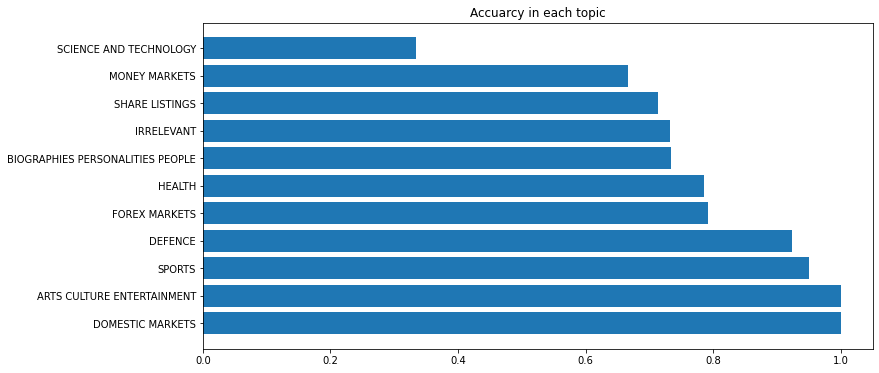

In [138]:
report(res_df['label'], res_df['predict'])
evaluate(res_df, 'label', 'predict')

In [73]:
# recommandation
with open('recommandation.txt', 'w') as f:
    f.write('1 level_1 no weight\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))

In [80]:
# recommandation
with open('recommandation_1.txt', 'w') as f:
    f.write('1 level_1 add_weight IRRE 3\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')


In [85]:
# recommandation
with open('recommandation_2.txt', 'w') as f:
    f.write('1 level_1 add_weight IRRE 3 BIO 2 HEALTH 1 MONEY 3\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')


In [94]:
# recommandation
with open('recommandation_3.txt', 'w') as f:
    f.write('3 level_1 add_weight BIO 2 HEALTH 1 MONEY 3\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')


In [110]:
# recommandation
with open('recommandation_4.txt', 'w') as f:
    f.write('3 level_1 add_weight all\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')

In [146]:
# ADD_WEIGHT_LIST = [0 for _ in topic_list]
# ADD_WEIGHT_LIST[topic_encode['BIOGRAPHIES PERSONALITIES PEOPLE']] = 2
# ADD_WEIGHT_LIST[topic_encode['HEALTH']] = 1
# ADD_WEIGHT_LIST[topic_encode['MONEY MARKETS']] = 3

topic_count = {}
for topic in topic_list:
    topic_count[topic] = 0
    
for model in model_list_1 + model_list_2:
    for topic in model.topic:
        topic_count[topic] += 1
# ADD_WEIGHT_LIST = [topic_count[max(topic_count)]-i for i in topic_count.values()]

ADD_WEIGHT_LIST = [topic_count[max(topic_count)]/i for i in topic_count.values()]

def vote_proba_3(votes, topic_dict, weights=None):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
                
        ###### add weight ######
#         if weights is not None:
#             for i in range(len(vote_count)):
#                 if vote_count[i] > 0:
#                     vote_count[i] += weights[i]
        if weights is not None:
            for i in range(len(vote_count)):
                vote_count[i] *= weights[i]
        ########################
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # no vote
        if max_vote == 0:
            res = [None, None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

def irre_vote_3(model_list, sample_size):
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
            print(clf.name)
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.predict(test_x)
            y_pred_proba = clf.predict_proba(test_x)
            print(y_pred)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]

                clf_name = clf.name.split('.')[0]
                # create namedtuple (model_name, category, category_proba)
                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    topic_dict = {0: 'IRRELEVANT', 1: 'RELEVANT'}
    return vote_proba_3(all_votes, topic_dict, [1, 0])

def cate_vote_3(model_list, sample_size, irre_res, truth):
    
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        print(clf.name)
        if clf.is_preprocess is True:
            test_x = dict_data[clf.test_set]
        else:
            test_x = dict_data['raw'][clf.test_set]
        y_pred = clf.predict(test_x)
        y_pred_proba = clf.predict_proba(test_x)
        print(y_pred)
        for i in range(sample_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            if topic_decode[cate] in clf.topic:
                            
                clf_name = clf.name.split('.')[0]

                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    rela_res = vote_proba_3(all_votes, topic_decode, ADD_WEIGHT_LIST)
    for i in range(sample_size):
        if irre_res['predict'].iloc[i] == 'IRRELEVANT':
            final_res = [truth[i]] + irre_res.iloc[i].tolist()
        else:
            final_res = [truth[i]] + rela_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

irre_df = irre_vote_3(model_list_1, SAMPLE_SIZE)
res_df = cate_vote_3(model_list_2, SAMPLE_SIZE, irre_df, df['topic'])

svm_ir_clf.joblib
[0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 

[ 3  6  4  6  6  4  2 10  7  9  9  6 10 10  6  7  6  9  3 10  6  4  7  6
  7  1  6  7  4  4  4  4  1  7  6 10  3  6  4  6 10  4  6  8  2  1  7  4
  3  4  4  3  7  4  4  6  9  6  2  7  4  9  9  4  4  6  4 10 10  4  7  4
 10 10  1  2  4  6  2 10  9  1  7  4  6  7  7  4  4  6  3  6  6  4  6 10
 10  6  4  7  9  7  6  1  9  7  2 10  5 10  4  6  4  9  6  2  8  7  2 10
  5  9  7  6  4  4  4  6  6 10  6  4  6  4  6  6  6  7  6  3  7  6  3  6
  1  6  4  2  4  4  3  9 10  9  9 10 10  9  4  6  5 10 10  6  4  9  9  6
  1  2  4  7  2  6  7  4  4  4  2  7  6  4  7  9  4  6  6  9  3  6  7  3
  4 10 10  4  3  1  6  9 10  4  0  4  6  2  7  4  4  4  4  9  2  2  9  6
  4  4  6  7  2  8  7  1  4  6  9  6  4  9  2  9  4  4  5 10  7 10  2  4
  2  9  4  7  6  7  9  4  7  3  4 10  3 10  7  6 10  1  2 10  7  6 10  1
  7  7  3  1  7  2  2  4  2 10  5  4  2  7  4  3  9 10  2  4  6  4 10  6
  0  6 10  7  6  6  3  3  1  4  1 10 10  3  7  9  7  4  5  6 10  5 10  9
 10  6  2  7 10 10  6  7 10  7  4  7  4  4  6  7  7

In [147]:
irre_df

,predict,mean_proba,models,probas
0,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
2,None,NaN,None,None
3,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...
495,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
496,None,NaN,None,None
497,None,NaN,None,None
498,IRRELEVANT,0.740054,[svm_ir_clf],[0.7400541593058131]


In [148]:
res_df

,label,predict,mean_proba,models,probas
0,IRRELEVANT,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
2,FOREX MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[0.9999999999997726]
3,IRRELEVANT,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...,...
495,IRRELEVANT,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
496,SPORTS,SPORTS,1.000000,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[1.0, 1.0, 1.0, 0.9999999995165704, 0.99999995..."
497,MONEY MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[1.0]
498,SHARE LISTINGS,IRRELEVANT,0.740054,[svm_ir_clf],[0.7400541593058131]


Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.33      0.67      0.44         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.62      0.33      0.43        15
                         DEFENCE       1.00      0.23      0.38        13
                DOMESTIC MARKETS       0.00      0.00      0.00         2
                   FOREX MARKETS       0.61      0.77      0.68        48
                          HEALTH       0.78      0.50      0.61        14
                      IRRELEVANT       0.85      0.92      0.88       266
                   MONEY MARKETS       0.67      0.59      0.63        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.00      0.00      0.00         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.80       500
             

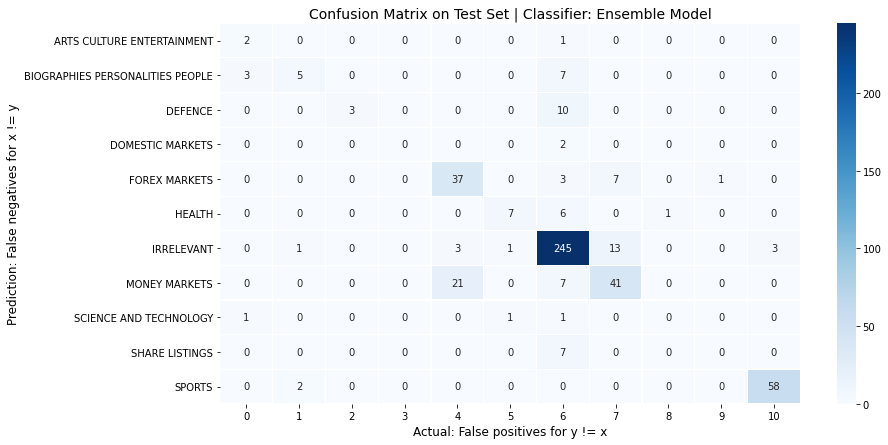

DEFENCE accuarcy is:				 0.23076923076923078
DOMESTIC MARKETS accuarcy is:				 0.0
MONEY MARKETS accuarcy is:				 0.5942028985507246
FOREX MARKETS accuarcy is:				 0.7708333333333334
SPORTS accuarcy is:				 0.9666666666666667
SHARE LISTINGS accuarcy is:				 0.0
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is:				 0.3333333333333333
HEALTH accuarcy is:				 0.5
ARTS CULTURE ENTERTAINMENT accuarcy is:				 0.6666666666666666
SCIENCE AND TECHNOLOGY accuarcy is:				 0.0
IRRELEVANT accuarcy is:				 0.9210526315789473


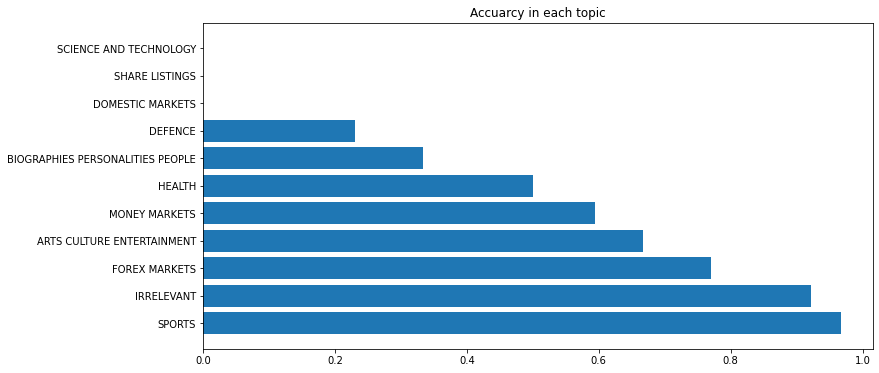

In [149]:
report(res_df['label'], res_df['predict'])
evaluate(res_df, 'label', 'predict')

In [119]:
# recommandation
with open('recommandation_5.txt', 'w') as f:
    f.write('3 level_1 add_weight all\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')

In [125]:
# recommandation
with open('recommandation_6.txt', 'w') as f:
    f.write('1 level_1 add_weight all\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')

In [126]:
topic_count

{'ARTS CULTURE ENTERTAINMENT': 3,
 'BIOGRAPHIES PERSONALITIES PEOPLE': 2,
 'DEFENCE': 4,
 'DOMESTIC MARKETS': 5,
 'FOREX MARKETS': 4,
 'HEALTH': 2,
 'IRRELEVANT': 1,
 'MONEY MARKETS': 1,
 'SCIENCE AND TECHNOLOGY': 1,
 'SHARE LISTINGS': 4,
 'SPORTS': 8}

In [145]:
# recommandation
with open('recommandation_7.txt', 'w') as f:
    f.write('3 level_1 times_weight all\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')

In [150]:
# recommandation
with open('recommandation_8.txt', 'w') as f:
    f.write('3 level_1 times_weight all special level 1\n')
    for topic in topic_list:
        if topic != "irrelavant":
            df_filter = res_df[res_df['predict'] == topic]
            f.write(topic)
            f.write('\n')
            f.write(str(df_filter.sort_values(by="mean_proba")['label'].head(10)))
            f.write('\n')

In [151]:
df

,Unnamed: 0,article_number,article_words,topic,key_word_10,key_word_20,key_word_50,key_word_100
0,0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT,"world,chin,chin,chin,chin,chin,chin,million,mi...","world,chin,chin,chin,chin,chin,chin,industr,gr...","world,chin,chin,chin,chin,chin,chin,industr,gr...","world,chin,chin,chin,chin,chin,chin,city,indus..."
1,1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT,report,"eu,includ,report","sunday,friday,eu,includ,european,report,saturday","sunday,friday,eu,includ,european,commun,servic..."
2,2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS,"stock,stock,stock,rate,rate,rate,day,day,day,p...","cent,cent,cent,stock,stock,stock,rate,rate,rat...","cent,cent,cent,stock,stock,stock,rate,rate,rat...","cent,cent,cent,recent,stock,stock,stock,rate,r..."
3,3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT,"day,work,offic,year,year,year,year,percent,per...","research,industr,industr,industr,industr,group...","research,comput,comput,comput,comput,comput,co...","research,hit,comput,comput,comput,comput,compu..."
4,4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT,"stat,stat,stat,stat,stat,stat,stat,bank,year,r...","case,end,unit,unit,unit,unit,stat,stat,stat,st...","court,court,case,end,unit,unit,unit,unit,stat,...","court,court,case,rule,rule,law,end,unit,unit,u..."
...,...,...,...,...,...,...,...,...
495,495,9996,"symantec,soon,interfac,provid,provid,comput,co...",IRRELEVANT,"year,year,year,compan,compan,system,produc,mar...","end,end,unit,unit,unit,includ,includ,year,year...","comput,comput,comput,comput,end,end,unit,unit,...","comput,comput,comput,comput,end,end,unit,unit,..."
496,496,9997,"hit,hit,hit,hit,hit,hit,hit,hit,hit,beat,beat,...",SPORTS,"scor,scor,scor,scor,scor,scor,scor,play,work,w...","beat,beat,scor,scor,scor,scor,scor,scor,scor,e...","beat,beat,scor,scor,scor,scor,scor,scor,scor,e...","hit,hit,hit,hit,hit,hit,hit,hit,hit,beat,beat,..."
497,497,9998,"cent,cent,cent,cent,match,declin,act,rate,rate...",MONEY MARKETS,"match,rate,rate,rate,rate,rate,rate,day,day,ba...","cent,cent,cent,cent,match,act,rate,rate,rate,r...","cent,cent,cent,cent,match,act,rate,rate,rate,r...","cent,cent,cent,cent,match,act,rate,rate,rate,r..."
498,498,9999,"cnmv,cnmv,stock,count,count,week,group,friday,...",SHARE LISTINGS,"stock,bank,shar,percent,market,trad","stock,week,group,bank,shar,percent,suspend,sus...","stock,week,group,friday,franc,bank,shar,bid,bi...","stock,week,group,friday,franc,bank,shar,bid,bi..."


In [152]:
res_df.set_index(df.article_number)

,label,predict,mean_proba,models,probas
article_number,,,,,
9501,IRRELEVANT,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
9502,IRRELEVANT,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
9503,FOREX MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[0.9999999999997726]
9504,IRRELEVANT,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
9505,IRRELEVANT,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...,...
9996,IRRELEVANT,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
9997,SPORTS,SPORTS,1.000000,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[1.0, 1.0, 1.0, 0.9999999995165704, 0.99999995..."
9998,MONEY MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[1.0]


In [153]:
res_df

,label,predict,mean_proba,models,probas
0,IRRELEVANT,IRRELEVANT,0.855460,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9415586552948044, 1.0, 0.6248227956728621]"
1,IRRELEVANT,IRRELEVANT,0.798582,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9294322124011538, 1.0, 0.46631374746266774]"
2,FOREX MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[0.9999999999997726]
3,IRRELEVANT,IRRELEVANT,0.783383,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.8360490328877616, 1.0, 0.5140987736785823]"
4,IRRELEVANT,IRRELEVANT,0.984085,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9852943113674895, 1.0, 0.9669618390243637]"
...,...,...,...,...,...
495,IRRELEVANT,IRRELEVANT,0.834089,"[svm_ir_clf, rel_clf_tfidf_NB, best_logi]","[0.9740126783506491, 1.0, 0.5282558161717601]"
496,SPORTS,SPORTS,1.000000,"[tfidf_logi_pipe, clf_NB_1, clf_NB_2, svm_prob...","[1.0, 1.0, 1.0, 0.9999999995165704, 0.99999995..."
497,MONEY MARKETS,MONEY MARKETS,1.000000,[clf_NB_2],[1.0]
498,SHARE LISTINGS,IRRELEVANT,0.740054,[svm_ir_clf],[0.7400541593058131]
